# SYDE 411 Optimization Project

## Team members:

- Sammy Robens-Paradise, 20709541
- Wassim Maj , 21048694
- <full_name> , <student_number>
- <full_name> , <student_number>


## Import Dependencies

Dependencies are `numpy` `matplotlib` and `scipy`. You can install both dependencies (assuming you have `Python >= 3` ) using pip:

- `pip install numpy`
- `pip install matplotlib`
- `pip install scipy`


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pulp

np.random.seed(18945)
# Some formating options
%config InlineBackend.figure_formats = ['svg']

## Problem Definition

The problem will be formulated as follows: Given 1 bus with a maximum capacity, $m$, we want to minimize the distance that the bus has to travel to $n$ locations (nodes) to pick up a total number of $P$ people where there are $p$ individual people located at each n location and drive the people to a central location c. Given the constraint of the bus size, this means that if $P \gt m$ the bus will need to pass through the central location $c$ more than 2 times (once leaving and once arriving) to go back out and collect the remaining people. Our objective function is to minimize the total distance travelled, which is in turn a function of the distance to each location, and the number of people at each location. It is constrained by the maximum bus capacity, $m$.

This problem has applications in shuttle bus schedules, especially in the tourist industry where it is often required to bring people from a number of different locations back to one central location (such as an event).


## Seeding Test Data

The first thing we need to do is create a function that will _seed_ test data so that we can have sudo-random data generated while also having repeatable and verifiable results. We are going to do this by creating a $n\times n\times p$ matrix where $n$ is the number of _nodes_ that are present in the data model. This means that for every node, we are also calculating the distance to each other node when we create our test data.

### Assumptions in The Data Model

We are assuming that all distances are in meters. We will assume that all of our locations exist within a $1000 \times 1000$-meter grid where each location is a distance of at least 1 meter away from another location, and no two locations have the same coordinate.


In [8]:
# delare constants to seed the data model

NUM_LOCATIONS = 10
NUM_PEOPLE = 100
VEHICLE_CAPACITY = 10
VEHICLES = 2
GRID_SIZE = {"x": 1000, "y": 1000}
SEED = 18945


# possible distances are
# - "manhattan"
# - "euclidean"
# - "chebyshev"
DISTANCE_METHOD = "manhattan"


def distance(
    p1,
    p2,
    method="manhattan",
):
    # make sure that the distance is between only a coordinate
    assert len(p1) == len(p2) == 2
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]

    d = 0
    # if the locations are the same then we can automatically say the distance is 0
    if x1 == x2 and y1 == y2:
        return d
    if method == "manhattan":
        d = np.absolute(x1 - x2) + np.absolute(y1 - y2)
    if method == "euclidean":
        d = np.sqrt(np.power(x2 - x1, 2) + np.power(y2 - y1, 2))
    if method == "chebyshev":
        d = np.max([np.absolute(x2 - x1), np.absolute(y2 - y1)])
    return d


def generate_data(
    num_locations=NUM_LOCATIONS,
    num_people=NUM_PEOPLE,
    grid_size=GRID_SIZE,
    plot_grid=False,
    seed=None,
    distance_method="manhattan",
):
    # seed our data so that we have reproducable data
    if seed != None:
        np.random.seed(seed)
    locations = []
    for _ in range(num_locations):
        x_coord = np.random.randint(0, grid_size["x"])
        y_coord = np.random.randint(0, grid_size["y"])
        node_coord = [x_coord, y_coord]
        locations.append(node_coord)

    locations = np.array(locations)

    if plot_grid == True:
        plt.figure()
        plt.suptitle("Scatter plot of locations")
        plt.grid()
        plt.scatter(locations[:, 0], locations[:, 1])
        plt.xlabel("$x$ m")
        plt.ylabel("$y$ m")
        plt.xlim([0, grid_size["x"]])
        plt.ylim([0, grid_size["y"]])
        plt.show()

    location_data = []
    for c1 in locations:
        distances = []
        for c2 in locations:
            d = distance(c1, c2, method=distance_method)
            distances.append(d)
        location_data.append(distances)

    return np.array(location_data)


def generate_problem():
    return pulp.LpProblem("CVRP", pulp.LpMinimize)

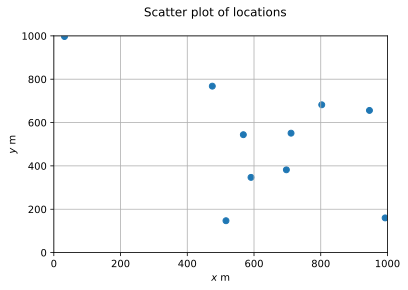

[[   0  373  989  291  449  317  809  490  220  150]
 [ 373    0 1086  406  822  414  712  169  547  223]
 [ 989 1086    0 1280 1334  672 1798 1255 1209 1125]
 [ 291  406 1280    0  416  608  518  523  141  183]
 [ 449  822 1334  416    0  662  490  939  275  599]
 [ 317  414  672  608  662    0 1126  583  537  453]
 [ 809  712 1798  518  490 1126    0  543  589  673]
 [ 490  169 1255  523  939  583  543    0  664  340]
 [ 220  547 1209  141  275  537  589  664    0  324]
 [ 150  223 1125  183  599  453  673  340  324    0]]


In [9]:
data = generate_data(plot_grid=True, seed=SEED)
print(data)


## Problem to Minimize

We can define a network $G=(V,E)$ that is the location and route of the people to pickup where:

$V={0,1,...,n}$ is a collection of nodes where $0$ represents the central location (start and endpoint).

$E$ is the set of edges connecting each node: $e_{ij}=(i,j)$

$K={1,2,...,|k|}$ is the number of vehicles available

$d_i \ge 0$ is the requied number of people to pickup $i$

$Q \ge 0$ is thte maxium vehicle capacity

$c_{ij}$ is the _cost_ to travel along an edge $e_{ij}$, i.e the distance between two locations

$x_{ij}^{k}$ is the decision variable about whether a route was chosen or not where $x_{ij}^{k}=1$ if the route was taken and $x_{ij}^{k}=0$ if the route was not taken

**The goal is to minimize the total cost of travel (travel distance) of all vehicles**

Consider the following:

### Objective function
(1) - $\min \sum_{k\in K}\sum_{(i,j)\in E} c_{ij} x_{ij}^{k}$

### Subject to:

(2) - $\sum_{k\in K}\sum_{i \in V,i \neq j} x_{ij}^{k} =1$ where $ \forall j \in V 	\setminus \{0\}$ - (2)

(3) - $\sum_{j \in V \setminus \{0\}} x_{0j}^{k}=1$ where $ \forall k \in K$

(4) - $\sum_{i \in V, i \neq j} x_{ij}^{k} - \sum_{i \in V} x_{ij}^{k}=0$ where $\forall j \in V, \forall k \in K$

(5) - $\sum_{i \in V} \sum_{j in V \ \{0\}, i \neq j } q_{j}x_{ij}^{j} \le Q$ where $\forall k \in K$

(6) - $\sum_{k \in K} \sum_{(i,j) \in S, i \neq j} x_{ij}^{k} \le |S|-1$ where $S \subseteq \setminus \{0\}$

(7) - $x_{ij}^{k} \in \{0,1\}$ where $\forall k \in K, \forall (i,j) \in E$


### Where

**(1)** is the _objective function_, **(2)** is the constraint such that there can only be one visit per vehicle per location, **(3)** requires the vechicle to depart from the central location, **(4)** requires the number of vehicles entering and leaving the centeral location must be the same, **(5)** requires that the capacity of the vehicles at any give point cannot exceed the maximum vehicle capacity, **(6)** remove _subtrips_ for every point, **(7)** Decision variables must be either 0 or 1.



## Minimization Problem

In [11]:
for bus in range(1, VEHICLES + 1):
    problem = generate_problem()
    x = [
        [
            [
                pulp.LpVariable("x%s_%s,%s" % (i, j, k), cat="Binary")
                if i != j
                else None
                for k in range(VEHICLES)
            ]
            for j in range(NUM_PEOPLE)
        ]
        for i in range(NUM_PEOPLE)
    ]
    print(x)

[[[None, None], [x0_1,0, x0_1,1], [x0_2,0, x0_2,1], [x0_3,0, x0_3,1], [x0_4,0, x0_4,1], [x0_5,0, x0_5,1], [x0_6,0, x0_6,1], [x0_7,0, x0_7,1], [x0_8,0, x0_8,1], [x0_9,0, x0_9,1], [x0_10,0, x0_10,1], [x0_11,0, x0_11,1], [x0_12,0, x0_12,1], [x0_13,0, x0_13,1], [x0_14,0, x0_14,1], [x0_15,0, x0_15,1], [x0_16,0, x0_16,1], [x0_17,0, x0_17,1], [x0_18,0, x0_18,1], [x0_19,0, x0_19,1], [x0_20,0, x0_20,1], [x0_21,0, x0_21,1], [x0_22,0, x0_22,1], [x0_23,0, x0_23,1], [x0_24,0, x0_24,1], [x0_25,0, x0_25,1], [x0_26,0, x0_26,1], [x0_27,0, x0_27,1], [x0_28,0, x0_28,1], [x0_29,0, x0_29,1], [x0_30,0, x0_30,1], [x0_31,0, x0_31,1], [x0_32,0, x0_32,1], [x0_33,0, x0_33,1], [x0_34,0, x0_34,1], [x0_35,0, x0_35,1], [x0_36,0, x0_36,1], [x0_37,0, x0_37,1], [x0_38,0, x0_38,1], [x0_39,0, x0_39,1], [x0_40,0, x0_40,1], [x0_41,0, x0_41,1], [x0_42,0, x0_42,1], [x0_43,0, x0_43,1], [x0_44,0, x0_44,1], [x0_45,0, x0_45,1], [x0_46,0, x0_46,1], [x0_47,0, x0_47,1], [x0_48,0, x0_48,1], [x0_49,0, x0_49,1], [x0_50,0, x0_50,1], [x